### Показы Рекламы 

На основе имеющихся данных сформулируйте рекомендации для рекламодателя.
- Какие дополнительные настройки нужно добавить в рекламные кампании, чтобы улучшить их эффективность?
    - Выставить таргетинги на отдельные группы пользователей
    - Ограничить время показа рекламы и.т.д
    
**Описание данных**
- `Device_id` – уникальный идентификатор девайса отправителя события
- `Device_type` – тип девайса
- `Datetime` – время отправки события
- `Ev_type` – тип события (0 – показ, 1 – клик)
- `Adv_type` – тип рекламы
- `Region_id` – регион отправителя события
- `Age` – возраст отправителя события
- `Gender` – пол отправителя события (1 – женщины, 2 – мужчины)


In [35]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Загрузка данных и Preprocessing

In [36]:
data = pd.read_csv('data/displays.csv', parse_dates=['datetime'])
data.head()

,device_id,device_type,datetime,ev_type,adv_type,region_id,age,gender
0,100001,android,2019-03-01 15:58:02,0,multi,2,14,2
1,100001,android,2019-03-01 17:13:53,0,multi,2,14,2
2,100002,android,2019-03-01 23:13:25,0,multi,2,0,0
3,100002,android,2019-03-01 23:25:06,0,multi,2,0,0
4,100003,android,2019-03-01 15:27:53,0,multi,1,0,0


In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265403 entries, 0 to 265402
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   device_id    265403 non-null  int64         
 1   device_type  265403 non-null  object        
 2   datetime     265403 non-null  datetime64[ns]
 3   ev_type      265403 non-null  int64         
 4   adv_type     265403 non-null  object        
 5   region_id    265403 non-null  int64         
 6   age          265403 non-null  int64         
 7   gender       265403 non-null  int64         
dtypes: datetime64[ns](1), int64(5), object(2)
memory usage: 16.2+ MB


In [38]:
# приведем данные к удобному формату (лично мне =) )
new_columns = {
    'ev_type': 'event_type',
    'adv_type': 'ad_type'
}

data = data.rename(new_columns, axis=1)
data['event_type'] = data['event_type'].map({0: 'display', 1: 'click'})
data['gender'] = data['gender'].map({0: 'unknown', 1: 'female', 2: 'male'})

### Первоначальный EDA

In [39]:
# device_id
display(
    data['device_id'].value_counts().head(10),
    data['device_id'].value_counts().tail(10)
)

100288    50
101717    38
100825    32
100735    31
102186    31
102185    31
102429    31
101111    30
101618    30
101363    30
Name: device_id, dtype: int64

281075    1
279026    1
285169    1
283120    1
196675    1
211012    1
208965    1
206918    1
219208    1
253153    1
Name: device_id, dtype: int64

- Имеем девайсы с которых просматривали рекламу несколько раз

In [40]:
# device_type
display(
    data['device_type'].value_counts().head(10),
    data['device_type'].value_counts().tail(10)
)

android    228595
ios         36808
Name: device_type, dtype: int64

android    228595
ios         36808
Name: device_type, dtype: int64

- всего 2 платформы (ios и android)

In [41]:
# datetime
data['datetime'].min(), data['datetime'].max()

(Timestamp('2019-03-01 00:00:01'), Timestamp('2019-03-09 23:59:56'))

- Имеем данные за 9 дней в Марте 

In [42]:
# event_type
data['event_type'].value_counts()

display    261295
click        4108
Name: event_type, dtype: int64

- Два соновных ивента - показ и клик

In [43]:
# ad_type
data['ad_type'].value_counts()

video    213993
multi     51410
Name: ad_type, dtype: int64

- 2 основных типа рекламы: видео и multi (смешанная)

In [44]:
# region_id
data['region_id'].value_counts()

1    211011
2     54392
Name: region_id, dtype: int64

- два региона (имеем больше показов в регионе 1, почти в 4 раза)

In [45]:
# age
data['age'].min(), data['age'].max()

(0, 75)

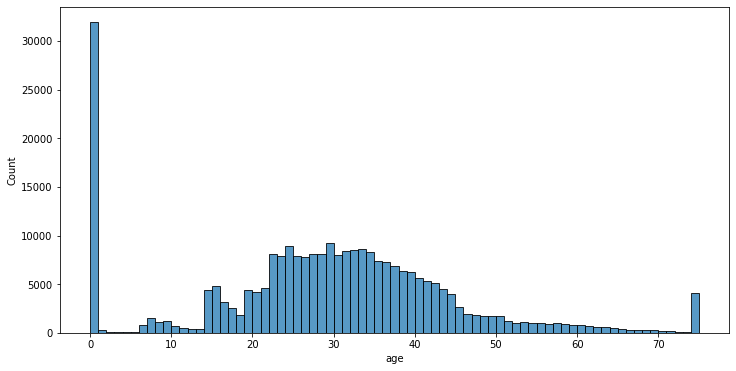

In [46]:
plt.figure(figsize=(12,6))
sns.histplot(data['age'], bins=75);

- Немного странные значения на хвостах распределения 

In [47]:
data['age'].value_counts().head(10)

0     31926
29     9273
24     8890
33     8566
32     8538
31     8451
34     8261
28     8148
22     8112
27     8054
Name: age, dtype: int64

In [48]:
display(
    data['age'].value_counts().head(10),
    data['age'].value_counts().tail(10)
)

0     31926
29     9273
24     8890
33     8566
32     8538
31     8451
34     8261
28     8148
22     8112
27     8054
Name: age, dtype: int64

69    239
70    197
71    138
5     115
2     105
74    104
72     99
73     90
3      63
4      57
Name: age, dtype: int64

In [49]:
# gender
data['gender'].value_counts().head(10),

(female     226616
 unknown     28347
 male        10440
 Name: gender, dtype: int64,)

### Тестирование Гипотез
Сформулируем ряд гипотез, которые позволят, например определить
- Лучшее время показа рекламы на конкретном устройстве в конкрретное время
- Как возраст влияет на CTR (тинейджеры, молодые, взрослые, пожилые)
- Влияет ли пол на рекламу?
- ...

### Как Оценивать Эффективность Рекламы
Для определения влияния разных признаков на эффективноть рекламы **будем использовать CTR**. Например, если видим, что CTR для женщин больше, чем для мужчин, то можно предположить, что пол влияет на рекламу и лучше отдать предпочтение женщинам и показывать рекламу им (вероятность клика больше).

In [50]:
def get_ctr(df, column):
    """
    Удобная функция для расчета CTR по категориям.
    
    """
    ctr = {}
    unique_values = df[column].unique()
    for val in unique_values:
        tmp_df = df[df[column] == val]
        try: # если клика нет 
            ctr[val] = (tmp_df['event_type'].value_counts()['click'] / tmp_df['event_type'].value_counts()['display'])*100
        except:
            ctr[val] = 0
    return ctr

### Ряд Вопросов
- В данных есть показы и клики с одних и тех же устройств - один пользователь?
- Есть пользователи с возрастом 0 ???
    - может возраст скрыт или неизвестен?
    - у таких пользователей обычно gender - unknown
- Есть пользователи с неизвестным полом
    - может пол скрыт или неизвестен?
    -  у таких пользователей возраст обычно - 0
    - возраст меняется у таких наблюдений, что нелогично 


In [51]:
# так как пользователи с возратсом 0 это что-то необычное, то их можно рассмотреть отдельно (предпочтительнее) либо исключить из анализа
zero_age_users = set(data[data['age'] == 0]['device_id'])
print('N UU (Zero Age): ', len(zero_age_users))

N UU (Zero Age):  12688


In [52]:
random_sample = random.sample(zero_age_users, 10)
print(random_sample)

[117729, 108084, 120540, 100429, 120242, 114091, 113278, 105444, 118617, 102401]


In [53]:
# исключим пользователей с неизвестным полом и для которых возраст равен 0 (нужно рассмотреть отдельно)
df = data[~data['device_id'].isin(zero_age_users)]

In [54]:
unique_dev = set(df['device_id'])
dev_many_events = set(df['device_id'].value_counts()[df['device_id'].value_counts() > 1].index)
dev_single_events = unique_dev.difference(dev_many_events)

print('N All Unique Devices: ', len(unique_dev))
print('N Unique Devices (More than 1 events): ', len(dev_many_events), ',', round(len(dev_many_events)/len(unique_dev)*100,2),'%')
print('N Unique Devices (Single Event): ', len(dev_single_events), ',', round(len(dev_single_events)/len(unique_dev)*100,2),'%')

N All Unique Devices:  174470
N Unique Devices (More than 1 events):  38337 , 21.97 %
N Unique Devices (Single Event):  136133 , 78.03 %


In [55]:
random_sample = random.sample(dev_many_events, 10)
print(random_sample)

[179204, 148487, 200948, 204597, 211576, 109216, 107059, 160523, 208969, 146006]


In [56]:
# теперь все выглядит стабильно: пользователь одного пола одного возраста использующий один device_id
df[df['device_id'] == 101929].head(10)

,device_id,device_type,datetime,event_type,ad_type,region_id,age,gender
8224,101929,android,2019-03-05 14:42:24,display,multi,1,14,male
8225,101929,android,2019-03-06 00:31:41,display,multi,1,14,male
8226,101929,android,2019-03-02 16:01:15,display,multi,1,14,male
8227,101929,android,2019-03-08 19:48:37,display,multi,1,14,male
8228,101929,android,2019-03-02 20:13:26,display,multi,1,14,male
8229,101929,android,2019-03-05 09:15:52,display,multi,1,14,male
8230,101929,android,2019-03-06 11:02:21,display,multi,1,14,male
8231,101929,android,2019-03-01 21:00:46,display,multi,1,14,male
8232,101929,android,2019-03-06 18:39:35,display,multi,1,14,male
8233,101929,android,2019-03-07 04:04:40,display,multi,1,14,male


### Добавим информацию о возвращении пользователя
- Добавим информацию о том, что пользователь заходил повторно
    - Эвристика: если время между 1 и вторым визитом > 1 дня
- Можно добавить сессии пользователя (нужно определить время жизни сессии: 12ч, 12ч, 1 день, и.т.д.)

In [57]:
%%time

# отсортируем по времени
df = df.groupby('device_id').apply(lambda x: x.sort_values('datetime')).reset_index(drop=True)

# найдем разницу между первым и последним визитом
res = df.groupby('device_id').apply(lambda x: x['datetime'].iloc[-1] - x['datetime'].iloc[0])

# найдем пользователей, которые вернулись 
returning_uu = set(res[res > pd.Timedelta(days=1)].index)
print('N UU (Returning): ', len(returning_uu))

df['is_returning'] = df['device_id'].isin(returning_uu)*1

N UU (Returning):  19820
Wall time: 3min 54s


### Варианты Решения Задачи
Так как есть данные по **рекламе одного рекламодателя в 2-х регионах**, то можно посмотреть на CTR рекламы по регионам и типу в разных разрезах (платформа, время, возраст, пол, ...). Посмотреть как данные парметры влияют на CTR и предложить оптимизацию. Например, реклама обычно стоит денег, поэтому для максиизации вероятности клика возможно имеет смысл показывать рекламу в определенное время суток для разных возрастных групп пользователей.

- Скорее всего регион играет важную роль, поэтому имеет смысл сделать сегментацию по этому признаку и по типу рекламы в нем

In [58]:
# сранвим, например, что CTR по регионам различатеся
regions_ctr = get_ctr(df=df, column='region_id')
regions_ctr

{2: 1.664372683959767, 1: 1.74362694186628}

In [59]:
# просегментируем
region_1_multi = df[(df['region_id'] == 1) & (df['ad_type'] == 'multi')]
region_1_video = df[(df['region_id'] == 1) & (df['ad_type'] == 'video')]

region_2_multi = df[(df['region_id'] == 2) & (df['ad_type'] == 'multi')]
region_2_video = df[(df['region_id'] == 2) & (df['ad_type'] == 'video')]

In [60]:
# взглянем на качество показво для разного типа рекламы по регионам
region_1_multi_сtr = get_ctr(df=region_1_multi, column='region_id')
region_1_video_сtr = get_ctr(df=region_1_video, column='region_id')

region_2_multi_сtr = get_ctr(df=region_2_multi, column='region_id')
region_2_video_сtr = get_ctr(df=region_2_video, column='region_id')


print('Качество (Регион 1 Multi): ', region_1_multi_сtr)
print('Качество (Регион 1 Video): ', region_1_video_сtr)
print('Качество (Регион 2 Multi): ', region_2_multi_сtr)
print('Качество (Регион 2 Video): ', region_2_video_сtr)

Качество (Регион 1 Multi):  {1: 0.33565881268921943}
Качество (Регион 1 Video):  {1: 1.871893418393961}
Качество (Регион 2 Multi):  {2: 0.36231884057971014}
Качество (Регион 2 Video):  {2: 1.789485899965185}


- Видно, что качестов одного типа в разных регионах изменяется. Посмотрим как мы модем их улучшить

#### Region 1 (Multi)
**CTR по полу**

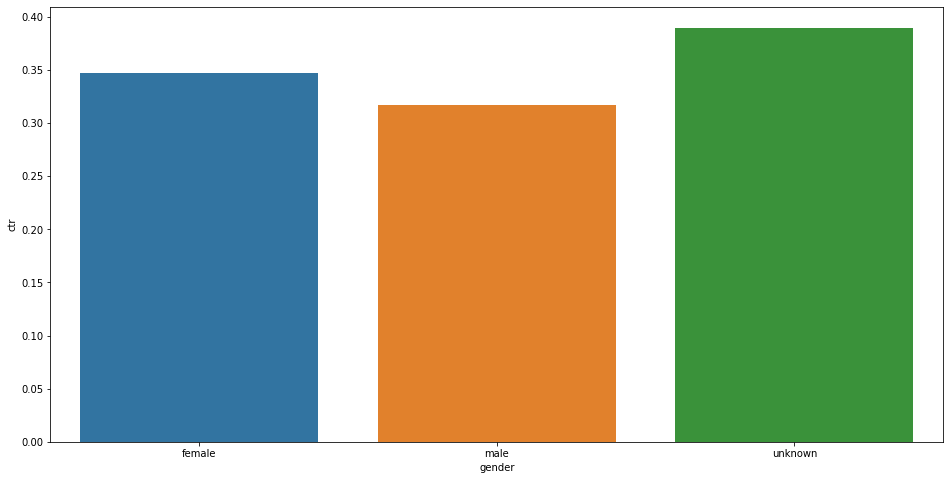

In [61]:
reg1_multi_gender_ctr = get_ctr(df=region_1_multi, column='gender')
reg1_multi_gender_ctr = pd.DataFrame({
    'gender': reg1_multi_gender_ctr.keys(),
    'ctr': reg1_multi_gender_ctr.values()
})

plt.figure(figsize=(16,8))
sns.barplot(data=reg1_multi_gender_ctr, x='gender', y='ctr');

- Можно предположить, что женщины более склонны к клику

**CTR по девайсу**

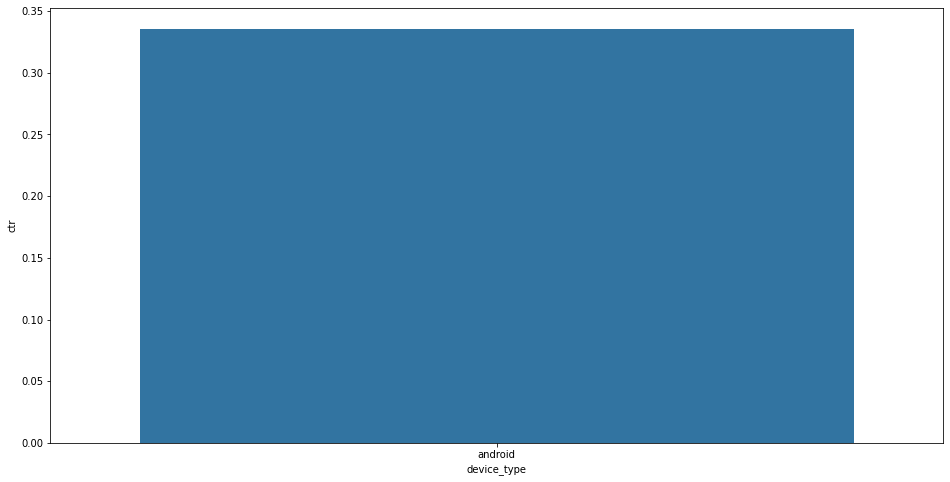

In [62]:
reg1_multi_device_ctr = get_ctr(df=region_1_multi, column='device_type')
reg1_multi_device_ctr = pd.DataFrame({
    'device_type': reg1_multi_device_ctr.keys(),
    'ctr': reg1_multi_device_ctr.values()
})

plt.figure(figsize=(16,8))
sns.barplot(data=reg1_multi_device_ctr, x='device_type', y='ctr');

- Имеем только android, ничего сказать не можем

**CTR по возвращению пользователей**

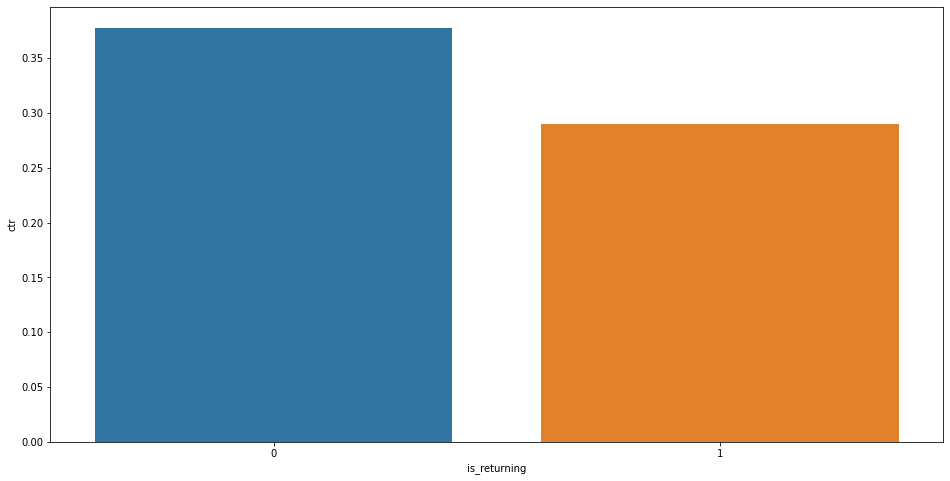

In [63]:
reg1_multi_return_ctr = get_ctr(df=region_1_multi, column='is_returning')
reg1_multi_return_ctr = pd.DataFrame({
    'is_returning': reg1_multi_return_ctr.keys(),
    'ctr': reg1_multi_return_ctr.values()
})

plt.figure(figsize=(16,8))
sns.barplot(data=reg1_multi_return_ctr, x='is_returning', y='ctr');

- Пользователи котоыре возвращаются менее склонны к клику (странно, возможно стоит перепроверить)

### CTR по времени 
Можно рассматривать в следующих разрезах
- Час
- Время суток: утро, день, вечер, ночь
- День недели: ПН, ВТ, СР, ...
- 

In [64]:
def get_time_features(series):
    """
    Функция, добавляющая признаки времени.
    
    """
    features_df = pd.DataFrame()
    features_df['datetime'] = series
    features_df['hour'] = series.dt.hour
    features_df['day_name'] = series.dt.day_name()
    features_df['is_weekend'] = series.dt.weekday.isin([5,6])*1

    lunch_time = set(map(lambda x: x.hour, pd.date_range('12:00:00', '13:00:00', freq='h').time))
    working_hours = set(map(lambda x: x.hour, pd.date_range('8:00:00', '19:00:00', freq='h').time))
    working_hours = working_hours - lunch_time
    features_df['is_working_hour'] = (
        features_df['datetime'].apply(lambda x: x.time().hour in working_hours)*1
    ).values
    features_df['is_lunch_time'] = (
        features_df['datetime'].apply(lambda x: x.time().hour in lunch_time)*1
    ).values
    
    features_df['day_of_time'] = pd.cut(
        features_df['datetime'].dt.hour,
        bins=[0, 6, 12, 18, 24],
        labels=['Ночь', 'Утро', 'День', 'Вечер'],
        right=False
    )
    return features_df 

In [65]:
time_features_df = get_time_features(region_1_multi['datetime'])

# добавим стобец с показами
time_features_df['event_type'] = region_1_multi['event_type']
time_features_df

,datetime,hour,day_name,is_weekend,is_working_hour,is_lunch_time,day_of_time,event_type
2,2019-03-01 15:31:17,15,Friday,0,1,0,День,display
3,2019-03-01 15:32:34,15,Friday,0,1,0,День,display
4,2019-03-01 15:33:10,15,Friday,0,1,0,День,display
5,2019-03-01 15:57:29,15,Friday,0,1,0,День,display
6,2019-03-01 22:05:59,22,Friday,0,0,0,Вечер,display
...,...,...,...,...,...,...,...,...
20605,2019-03-09 08:22:36,8,Saturday,1,1,0,Утро,display
20606,2019-03-09 04:04:30,4,Saturday,1,0,0,Ночь,display
20607,2019-03-09 16:19:29,16,Saturday,1,1,0,День,display
20608,2019-03-09 00:33:42,0,Saturday,1,0,0,Ночь,display


**Час**

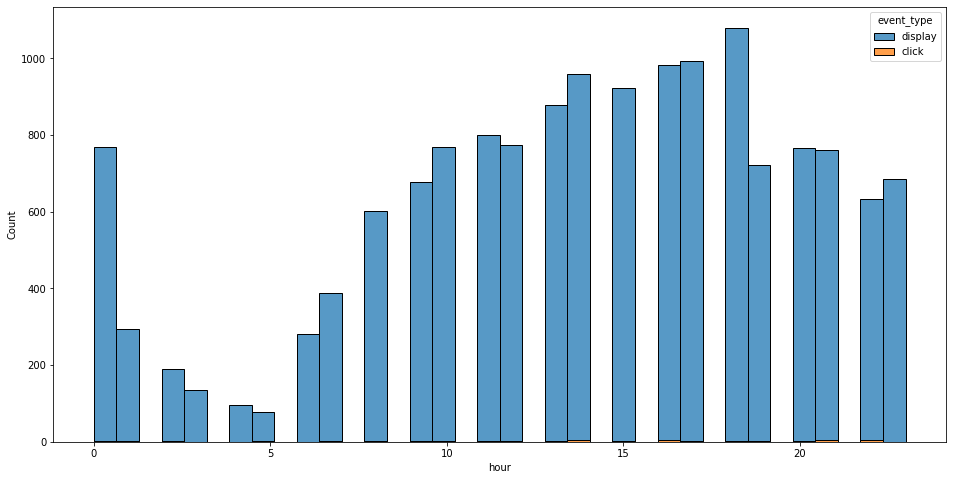

In [66]:
plt.figure(figsize=(16,8))
sns.histplot(data=time_features_df, x='hour', hue='event_type', multiple='stack');

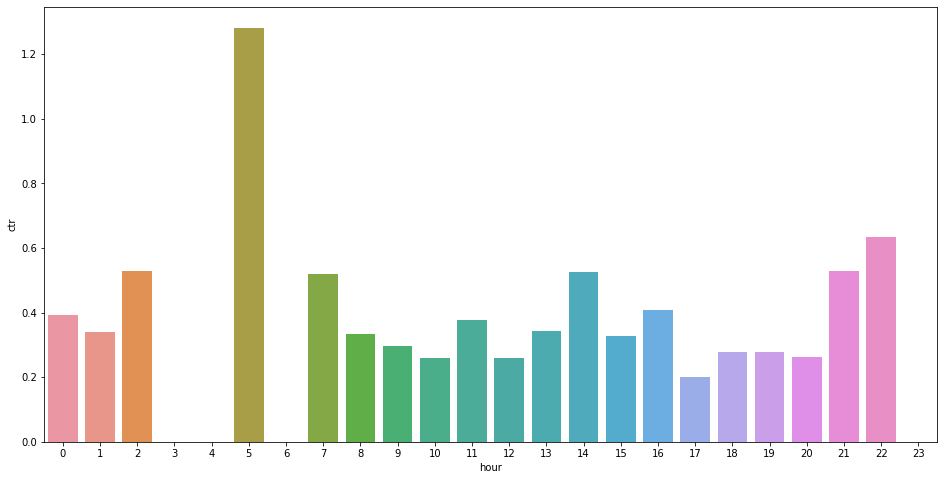

In [67]:
hour_ctr = get_ctr(df=time_features_df, column='hour')

hour_ctr_df = pd.DataFrame({
    'hour': hour_ctr.keys(),
    'ctr': hour_ctr.values()
})

plt.figure(figsize=(16,8))
sns.barplot(data=hour_ctr_df, x='hour', y='ctr');

- CTR максимален в 5, 22, 14 ...

**День Недели**

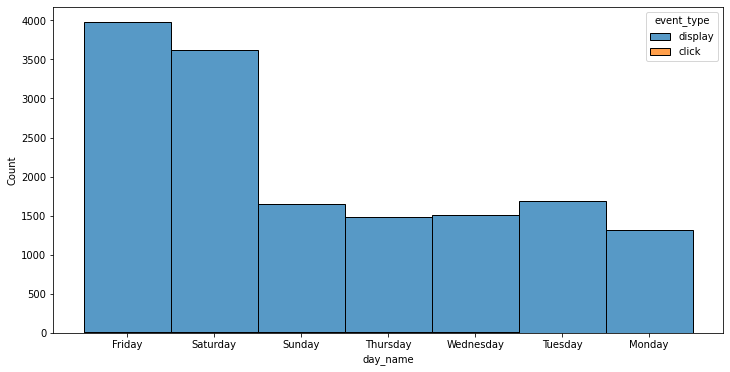

In [68]:
plt.figure(figsize=(12,6))
sns.histplot(data=time_features_df, x='day_name', hue='event_type', multiple='stack');

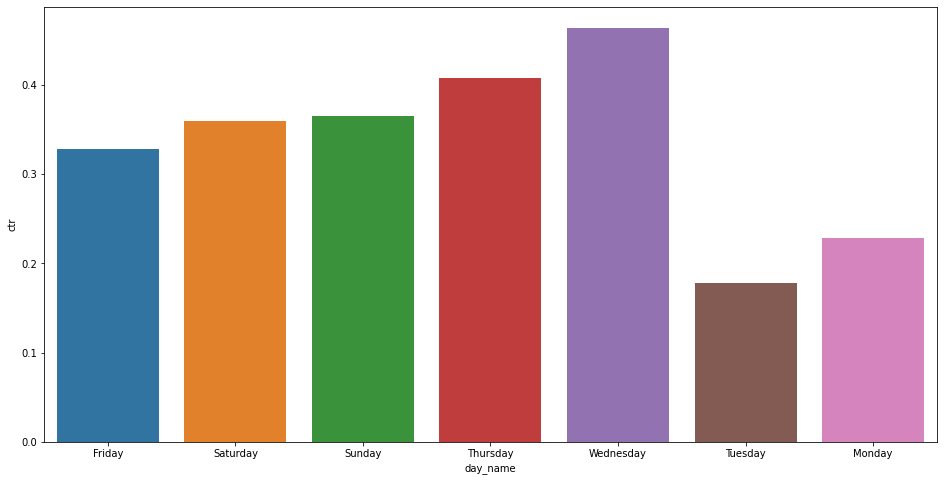

In [69]:
day_ctr = get_ctr(df=time_features_df, column='day_name')

day_ctr_df = pd.DataFrame({
    'day_name': day_ctr.keys(),
    'ctr': day_ctr.values()
})

plt.figure(figsize=(16,8))
sns.barplot(data=day_ctr_df, x='day_name', y='ctr');

- CTR максимален в Среду, Четверг и Воскресенье

**Выходные**

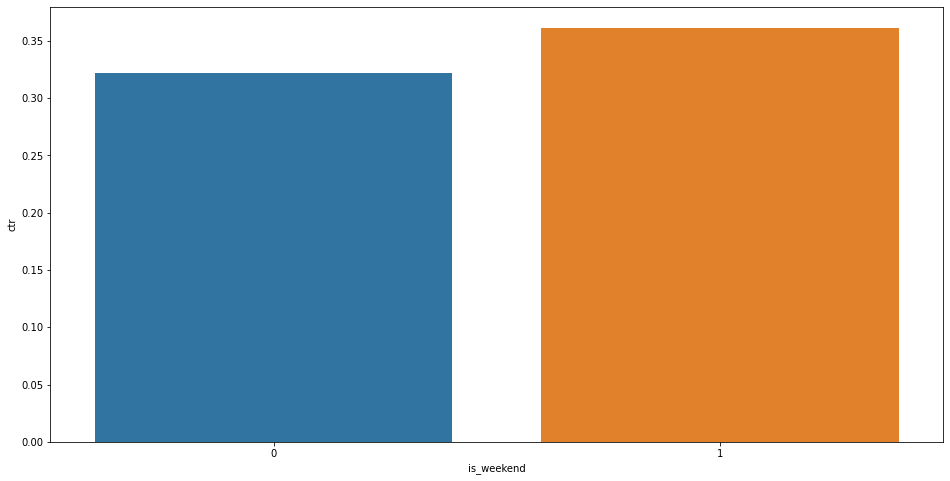

In [70]:
is_weekend_ctr = get_ctr(df=time_features_df, column='is_weekend')

is_weekend_ctr_df = pd.DataFrame({
    'is_weekend': is_weekend_ctr.keys(),
    'ctr': is_weekend_ctr.values()
})

plt.figure(figsize=(16,8))
sns.barplot(data=is_weekend_ctr_df, x='is_weekend', y='ctr');

- Есть небольшой uplift если это выходной день

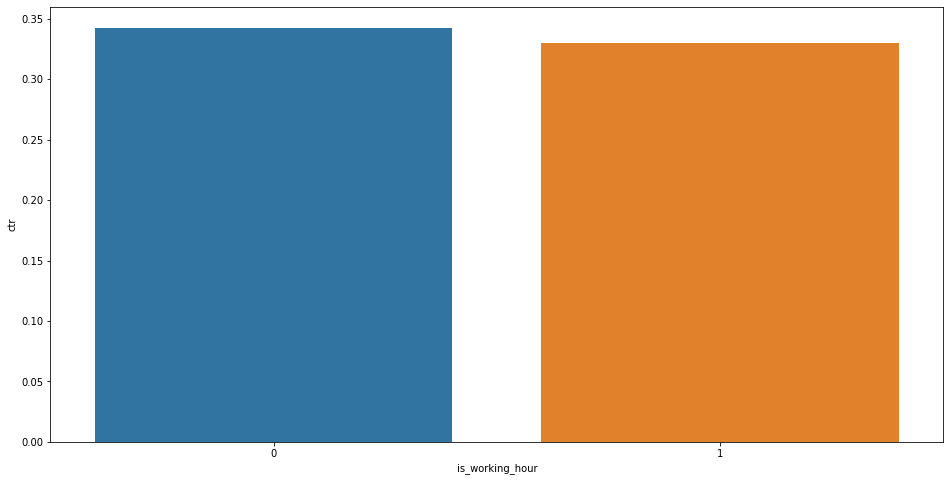

In [71]:
is_working_ctr = get_ctr(df=time_features_df, column='is_working_hour')

is_working_ctr_df = pd.DataFrame({
    'is_working_hour': is_working_ctr.keys(),
    'ctr': is_working_ctr.values()
})

plt.figure(figsize=(16,8))
sns.barplot(data=is_working_ctr_df, x='is_working_hour', y='ctr');

- Особого различия нет

**Обеденное Время**

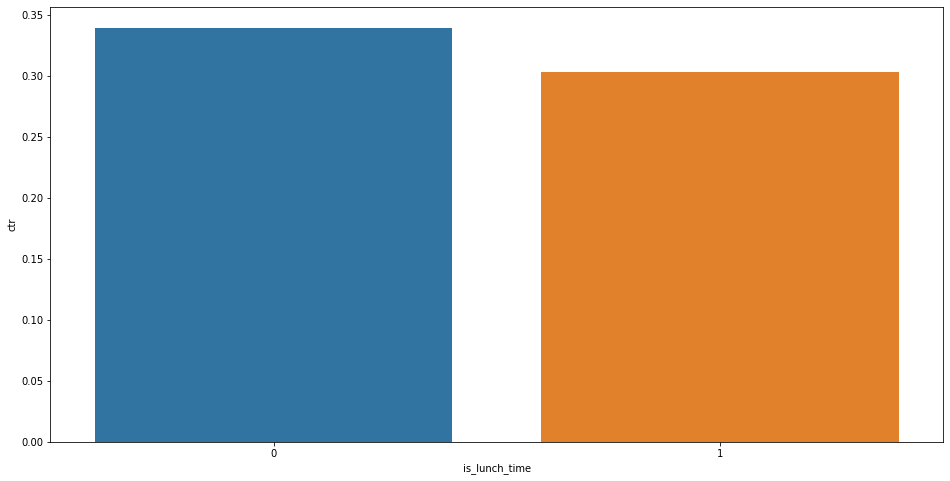

In [72]:
is_lunch_ctr = get_ctr(df=time_features_df, column='is_lunch_time')

is_lunch_ctr_df = pd.DataFrame({
    'is_lunch_time': is_lunch_ctr.keys(),
    'ctr': is_lunch_ctr.values()
})

plt.figure(figsize=(16,8))
sns.barplot(data=is_lunch_ctr_df, x='is_lunch_time', y='ctr');

- Негативынй Uplift, лучше избегать показа в обеденное время

**Время Суток**

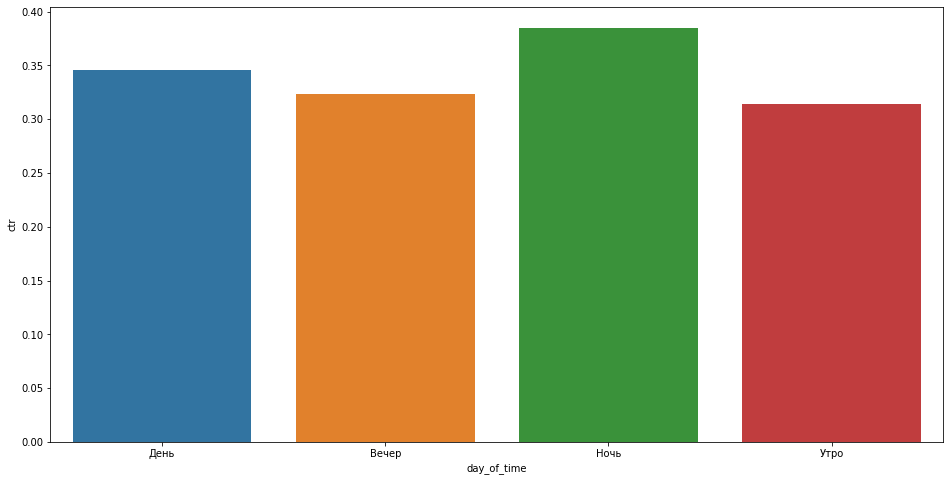

In [73]:
daytime_ctr = get_ctr(df=time_features_df, column='day_of_time')

daytime_ctr_df = pd.DataFrame({
    'day_of_time': daytime_ctr.keys(),
    'ctr': daytime_ctr.values()
})

plt.figure(figsize=(16,8))
sns.barplot(data=daytime_ctr_df, x='day_of_time', y='ctr');

- Ночное время выглядит предпочтительнее

**СTR по возрасту**

In [74]:
def assign_age_category(x):
    """
    Простая функция для определения возраста.
    
    """
    if x < 20:
        return '<20'
    elif x >= 20 and x < 30:
        return '20-30'
    elif x >= 30 and x < 40:
        return '30-40'
    elif x >= 40 and x < 50:
        return '40-50'
    else:
        return '>50'

In [75]:
region_1_multi['age_cat'] = region_1_multi['age'].apply(lambda x: assign_age_category(x))

c:\users\vlad\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [76]:
region_1_multi

,device_id,device_type,datetime,event_type,ad_type,region_id,age,gender,is_returning,age_cat
2,100004,android,2019-03-01 15:31:17,display,multi,1,38,female,0,30-40
3,100005,android,2019-03-01 15:32:34,display,multi,1,14,male,0,<20
4,100007,android,2019-03-01 15:33:10,display,multi,1,16,male,1,<20
5,100007,android,2019-03-01 15:57:29,display,multi,1,16,male,1,<20
6,100007,android,2019-03-01 22:05:59,display,multi,1,16,male,1,<20
...,...,...,...,...,...,...,...,...,...,...
20605,122963,android,2019-03-09 08:22:36,display,multi,1,14,female,0,<20
20606,122964,android,2019-03-09 04:04:30,display,multi,1,14,male,0,<20
20607,122965,android,2019-03-09 16:19:29,display,multi,1,43,male,0,40-50
20608,122966,android,2019-03-09 00:33:42,display,multi,1,32,male,0,30-40


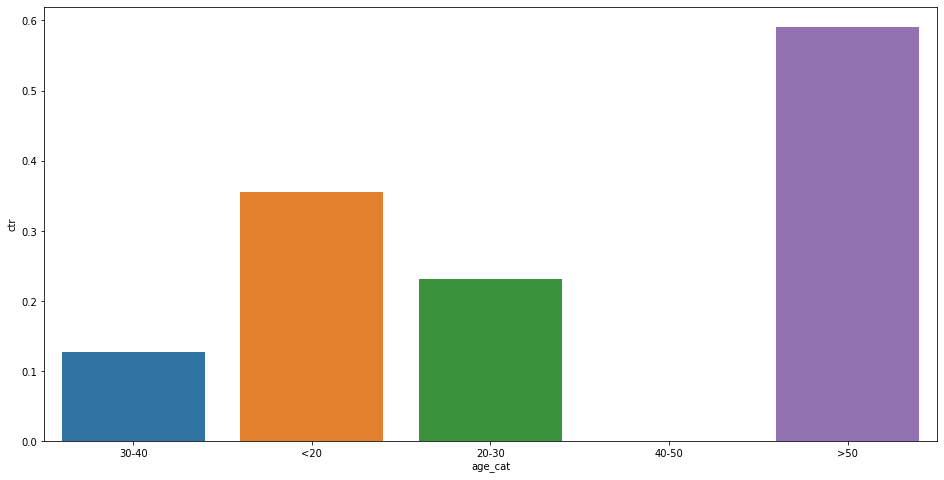

In [77]:
reg1_multi_age_ctr = get_ctr(df=region_1_multi, column='age_cat')
reg1_multi_age_ctr = pd.DataFrame({
    'age_cat': reg1_multi_age_ctr.keys(),
    'ctr': reg1_multi_age_ctr.values()
})

plt.figure(figsize=(16,8))
sns.barplot(data=reg1_multi_age_ctr, x='age_cat', y='ctr');

- Самый большой отклик из групп старше 50 и и младше 20

Можно сформулировать общую рекомендацию для максимального отклика на рекламу для региона 1 и типа multi
- Вариант_А: Показ рекламы рано утром (с 5:00) или днем пользователям женского пола в возрасте старше 50 в Среду, Четверг или Воскресенье 

#### Region 2 (Video)
**CTR по полу**

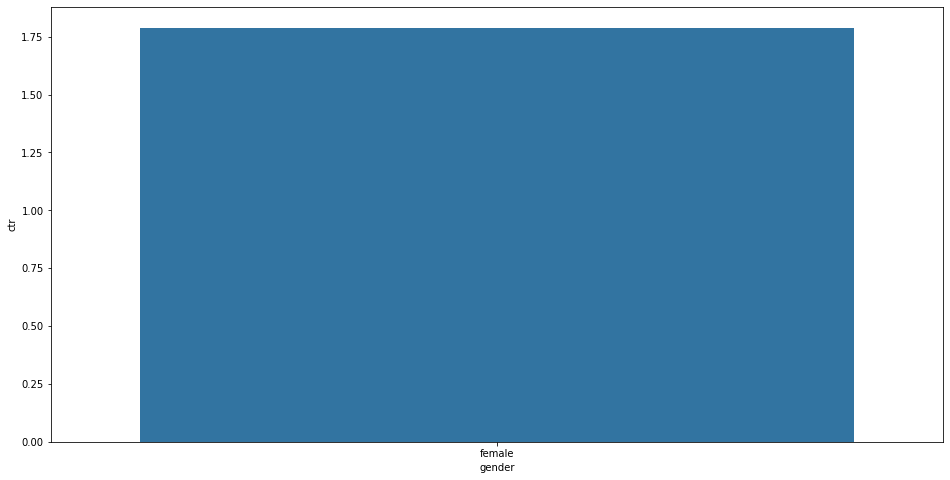

In [78]:
reg2_video_gender_ctr = get_ctr(df=region_2_video, column='gender')
reg2_video_gender_ctr = pd.DataFrame({
    'gender': reg2_video_gender_ctr.keys(),
    'ctr': reg2_video_gender_ctr.values()
})

plt.figure(figsize=(16,8))
sns.barplot(data=reg2_video_gender_ctr, x='gender', y='ctr');

- Нет сравнения

**CTR по девайсу**

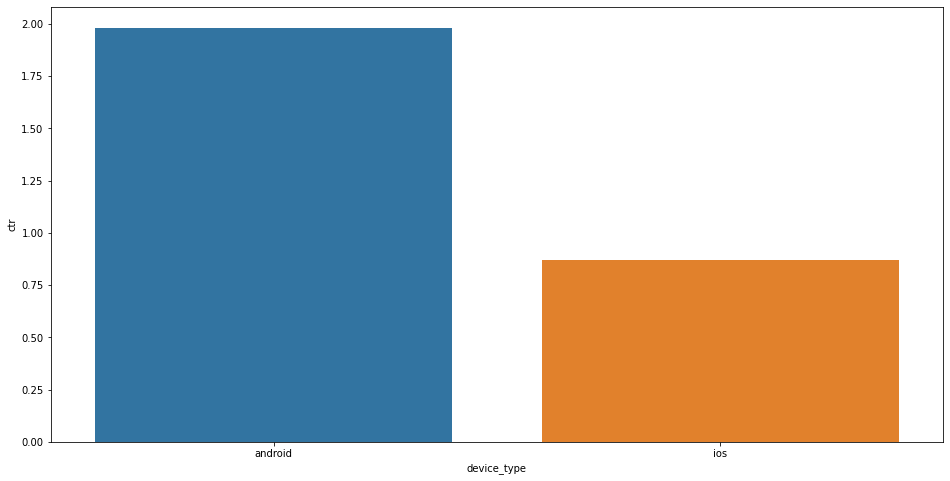

In [79]:
reg2_video_device_ctr = get_ctr(df=region_2_video, column='device_type')
reg2_video_device_ctr = pd.DataFrame({
    'device_type': reg2_video_device_ctr.keys(),
    'ctr': reg2_video_device_ctr.values()
})

plt.figure(figsize=(16,8))
sns.barplot(data=reg2_video_device_ctr, x='device_type', y='ctr');

- Видим довольно значимый uplift по `device_type`, лучше использовать `android`

**CTR по возвращению пользователей**

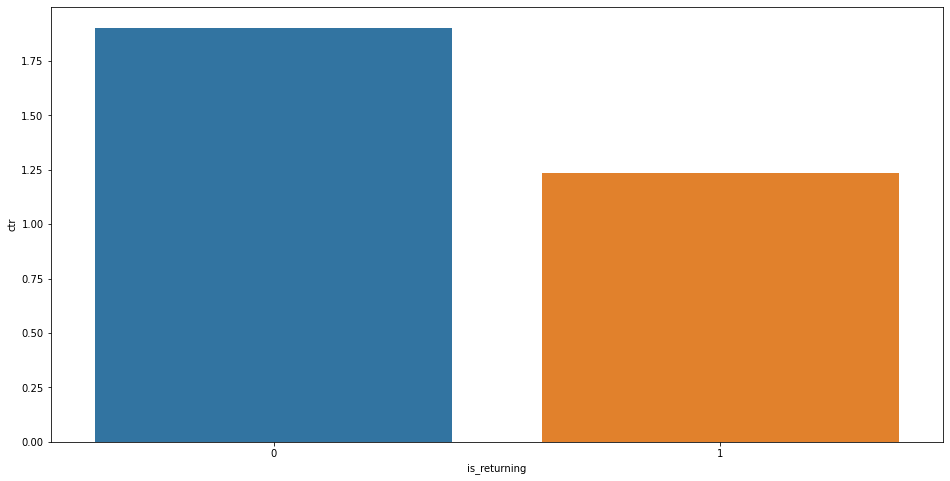

In [80]:
reg2_video_return_ctr = get_ctr(df=region_2_video, column='is_returning')
reg2_video_return_ctr = pd.DataFrame({
    'is_returning': reg2_video_return_ctr.keys(),
    'ctr': reg2_video_return_ctr.values()
})

plt.figure(figsize=(16,8))
sns.barplot(data=reg2_video_return_ctr, x='is_returning', y='ctr');

**Час**

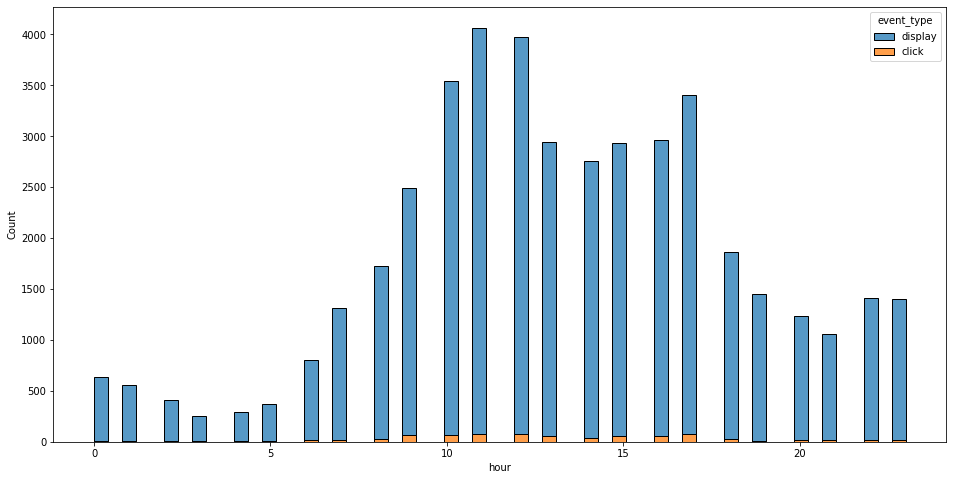

In [81]:
time_features_df = get_time_features(region_2_video['datetime'])

# добавим стобец с показами
time_features_df['event_type'] = region_2_video['event_type']
time_features_df

plt.figure(figsize=(16,8))
sns.histplot(data=time_features_df, x='hour', hue='event_type', multiple='stack');

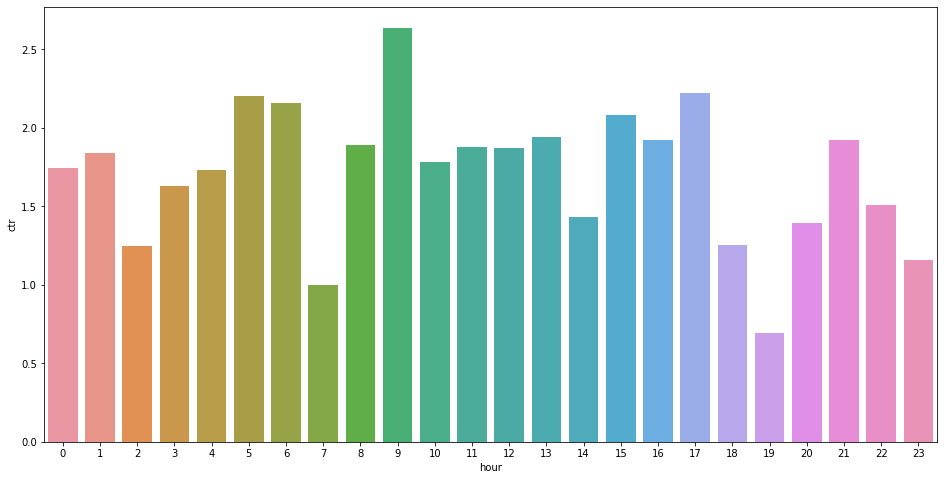

In [82]:
hour_ctr = get_ctr(df=time_features_df, column='hour')

hour_ctr_df = pd.DataFrame({
    'hour': hour_ctr.keys(),
    'ctr': hour_ctr.values()
})

plt.figure(figsize=(16,8))
sns.barplot(data=hour_ctr_df, x='hour', y='ctr');

**День Недели**

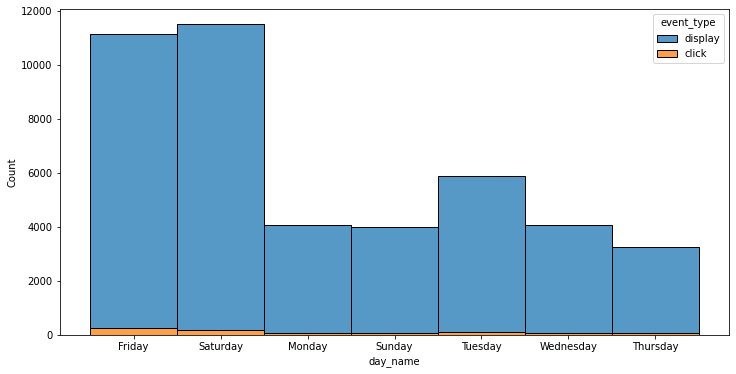

In [83]:
plt.figure(figsize=(12,6))
sns.histplot(data=time_features_df, x='day_name', hue='event_type', multiple='stack');

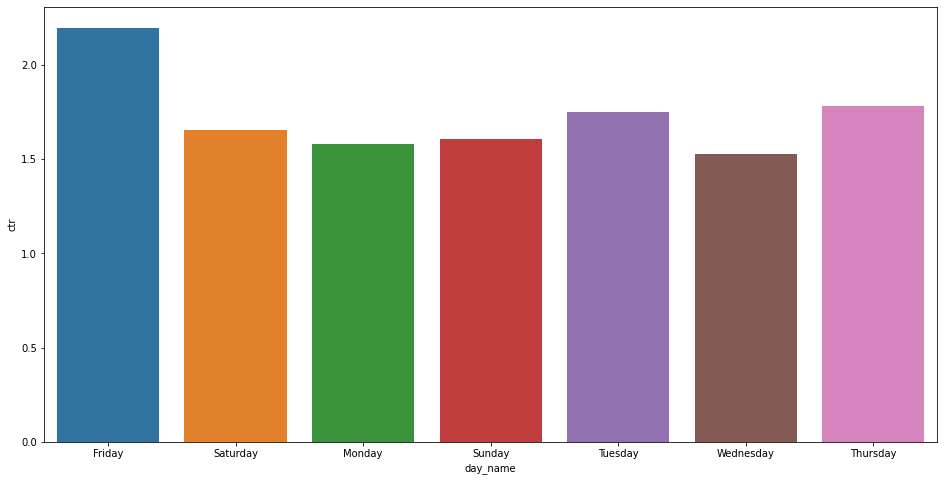

In [84]:
day_ctr = get_ctr(df=time_features_df, column='day_name')

day_ctr_df = pd.DataFrame({
    'day_name': day_ctr.keys(),
    'ctr': day_ctr.values()
})

plt.figure(figsize=(16,8))
sns.barplot(data=day_ctr_df, x='day_name', y='ctr');

**Время Суток**

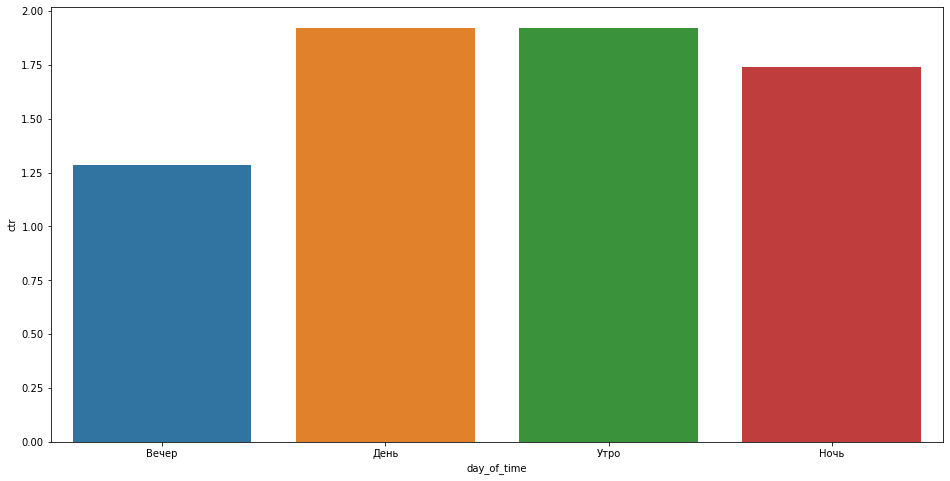

In [85]:
daytime_ctr = get_ctr(df=time_features_df, column='day_of_time')

daytime_ctr_df = pd.DataFrame({
    'day_of_time': daytime_ctr.keys(),
    'ctr': daytime_ctr.values()
})

plt.figure(figsize=(16,8))
sns.barplot(data=daytime_ctr_df, x='day_of_time', y='ctr');

**CTR по Возрасту**

In [86]:
region_2_video['age_cat'] = region_2_video['age'].apply(lambda x: assign_age_category(x))

c:\users\vlad\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


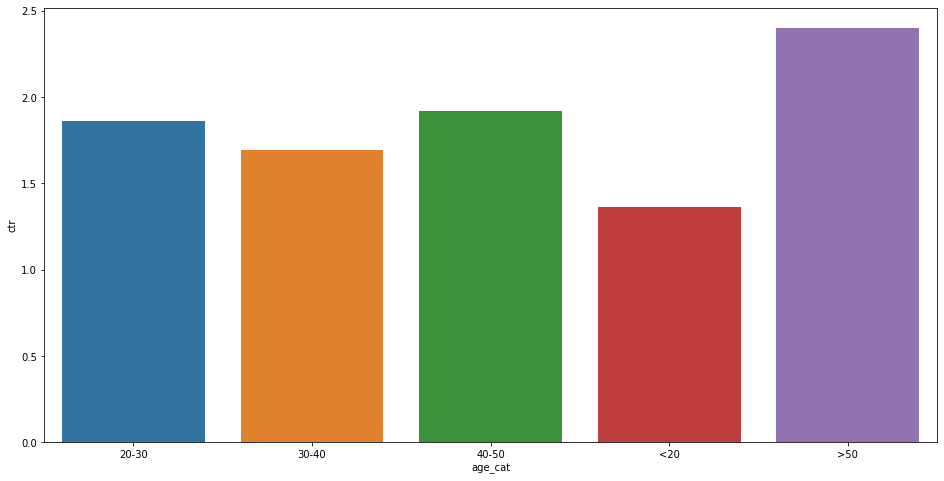

In [87]:
reg2_video_age_ctr = get_ctr(df=region_2_video, column='age_cat')
reg2_video_age_ctr = pd.DataFrame({
    'age_cat': reg2_video_age_ctr.keys(),
    'ctr': reg2_video_age_ctr.values()
})

plt.figure(figsize=(16,8))
sns.barplot(data=reg2_video_age_ctr, x='age_cat', y='ctr');

Можно сформулировать общую рекомендацию для максимального отклика на рекламу для региона 2 и типа video
- Показ рекламы рано утром (в 9:00) или днем пользователям с `android` в Пятницу или Четверг для пользователей старше 50 (или 40-50)

### Другие Методы 
- Для привлечения большего числа пользователей на конкретную рекламу можно обучить модель `LookALike` и показывать определенной доле новых пользователей рекламу тем самым увеличив трафик и CTR. Для этого необходимо разметить пользователей на следующие группы:
    - Целевые: клик по рекламе
    - Остальные: кто посмотрел, но не кликнул